- Goal
    - Create synthetic data using IDM
    - Learn parameters of that data using particle filtering
    - Aliter 7 Feb: Learn using CEM idea, fitness function and then distb and then sample
- Learning
    - Need at least 2 vehicles so that there is a neighbor in the front
    - Otherwise src/1d/driver/lane_follower_driver errors
    - That is why the `AutomotiveDrivingModels/doc/1DMobius` stuff does 
    not work with 1 car only (needs at least 2 cars)
    - The tutorial does not work with `gen_straight_roadway` because that
    generates a roadway of type AutomotiveDrivingModels.roadway as opposed to
    AutomotiveDrivingModels.StraightRoadway
- Open question
    - IDM won't work unless there is a car in front (errors saynig nothing in sight)
    - We are focusing on learning the params of the second car here. Is that sound sensible?

In [1]:
using AutomotiveDrivingModels
using AutoViz
using Reel
using Interact
using StatsBase # For random particle generation

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/5dc1e185f8b2175037a0bb4bac5baa1c8ca39ea5-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/5dc1e185f8b2175037a0bb4bac5baa1c8ca39ea5-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [57]:
# 1 lane, 1000 m roadway
# roadway = gen_straight_roadway(1,1000.0) # Does not work with the below because AutomotiveDrivingModels.Roadway
roadway = StraightRoadway(1000.0); # AutomotiveDrivingModels.StraightRoadway type

In [ ]:
typeof(roadway)

In [99]:
scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true,
        pos=VecE2(veh.state.s-0.7, 3)) for veh in scene];
# render(scene, roadway, overlays, cam=cam, canvas_height=100)

In [61]:
using Distributions

In [67]:
# Example of fitting data to a distribution
d = Normal() # Create a normal distribution
x = rand(d, 100) # Generate 100 samples from this distrib
fit(Normal, x)

Distributions.Normal{Float64}(μ=-0.045600852263753905, σ=1.0318305451937901)

In [ ]:
# Generate true trajectory

In [ ]:
# Generate set of particles

In [ ]:
# Loop over particles
    # Generate hallucinated trajectory
    # Compute fitness value associated with particle

In [ ]:
# Fit a Gaussian to the fitness vector generated

In [ ]:
# Sample set of particles

In [98]:
# Scene initialization function
function init_scene()
    scene = Scene1D()
    push!(scene, Entity(State1D(10.0, 8.0), VehicleDef(), 1))
    push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))
    return scene
end

init_scene (generic function with 1 method)

In [100]:
# Trajectory generation function
    # Calls init_scene
function gen_traj(param_vdes;nticks=100,timestep=0.1)
    scene = init_scene()
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=12.0) # always produce zero acceleration
    models[2] = IntelligentDriverModel(v_des=param_vdes)

    # Simulate for nticks (default 100) time steps
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)

    # Extract the position and velocity of nticks timesteps
    # X stores this as 2d array. Timestep is the row, col 1 is pos,vel is pos2
    n_cars = scene.n
    n_ticks = nticks
    X = Array{Float64}(n_ticks, 1)

    for t in 1:n_ticks
        f = rec.frames[n_ticks - t + 1]
        
        # BAD: 2 cars in scene therefore loop has only 1 elem
        for c in 2:scene.n #TODO: THIS IS A PITFALL AND IS HARDCODED
            s = f.entities[c].state
            X[t, 1] = s.s #position
        end
    end
    return X
end

gen_traj (generic function with 3 methods)

In [104]:
true_traj = gen_traj(20.0,nticks=10)

10×1 Array{Float64,2}:
 51.2627
 52.5506
 53.8632
 55.2003
 56.5613
 57.9459
 59.3534
 60.7836
 62.2359
 63.7098

In [105]:
test_traj = gen_traj(10.0,nticks=10)

10×1 Array{Float64,2}:
 51.2284
 52.4183
 53.5779
 54.7132
 55.8287
 56.9276
 58.0128
 59.0863
 60.1499
 61.2052

In [34]:
# Set of num_p particles in the range p_start_val to p_end_val
# Each particle represents a desired velocity that parametrizes
# the IDM model
p_start_val = 10.0
p_end_val = 30.0
num_p = 50
p_vdes = sample(p_start_val:p_end_val, num_p, replace = true);

In [ ]:
# Generate trajectories corresponding to all the particles

## Particle Filter Idea tabled for now

In [41]:
# Hallucinate a step using all the particles
raise()
for (i,my_v_des) in enumerate(p_vdes)
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=12.0) # always produce zero acceleration
    models[2] = IntelligentDriverModel(v_des=my_v_des) # default IDM with a desired speed of 12 m/s

    nticks = 0.1
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)
end

LoadError: [91mUndefVarError: raise not defined[39m

In [ ]:
# Compare every particles hallucination to
# the master trajectory (what actually happened)
# and assign a weight

In [59]:
models = Dict{Int, LaneFollowingDriver}()
models[1] = IntelligentDriverModel(v_des=12.0) # always produce zero acceleration
models[2] = IntelligentDriverModel(v_des=20.0) # default IDM with a desired speed of 12 m/s

nticks = 5
timestep = 0.1
rec = QueueRecord(Vehicle1D, nticks+1, timestep)
simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)
@show length(rec.frames)

length(rec.frames) = 6


6

In [21]:
fieldnames(rec.frames[1].entities[1].state)

2-element Array{Symbol,1}:
 :s
 :v

In [25]:
fieldnames(IntelligentDriverModel)

10-element Array{Symbol,1}:
 :a    
 :σ    
 :k_spd
 :δ    
 :T    
 :v_des
 :s_min
 :a_max
 :d_cmf
 :d_max

In [54]:
# From djp chmm bitbucket. src/toy_driving_data.jl
n_cars = scene.n
n_ticks = nticks
X = Array{Float64}(n_cars, n_ticks, 3)

for t in 1:n_ticks
    f = rec.frames[n_ticks - t + 1]
    for c in 1:scene.n
        s = f.entities[c].state
        X[c, t, 1] = s.s #position
        X[c, t, 2] = s.v #speed
    end
end

Ideas:
- Hallucination and weighting can happen in same iteration
- Should we correct the position of the car to what actually happened after every timestep

In [69]:
X

2×5×3 Array{Float64,3}:
[:, :, 1] =
 259.856  261.056  262.256  263.456  264.656
 458.881  460.878  462.875  464.871  466.868

[:, :, 2] =
 11.999   11.999   11.999   11.999  11.999
 19.9652  19.9652  19.9651  19.965  19.965

[:, :, 3] =
 6.92754e-310  6.92754e-310  6.92754e-310  6.92754e-310  6.92754e-310
 6.92754e-310  6.92754e-310  6.92754e-310  6.92754e-310  6.92754e-310

(div
  Widgets.Widget{:slider}(DataStructures.OrderedDict{Symbol,Any}(:changes=>Observables.Observable{Int64}("ob_08", 0, Any[WebIO.SyncCallback(WebIO.Scope("knockout-component-f727749a-af89-4c55-b212-4cce69074e03", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["frame_index"], Dict{Symbol,Any}(Pair{Symbol,Any}(:className, "interact "),Pair{Symbol,Any}(:style, Dict{Any,Any}(Pair{Any,Any}(:padding, "5px 10px 0px 10px")))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"text-align:right;width:18%"))), 2), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:max, 6),Pair{Symbol,Any}(:min, 1),Pair{Symbol,Any}(:attributes, Dict{Any,Any}(Pair{Any,Any}(:type, "range"),Pair{Any,Any}(Symbol("data-bind"), "numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}"))),Pair{Symbol,Any}(:step, 1),Pair{Symbol,Any}(:className, "slider slider is-fullwidth"),Pair{Symbol,Any}(:style, Dict{Any,Any}())), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"flex-grow:1; margin: 0 2%"))), 1), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("data-bind"=>"text: displayedvalue"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"width:18%"))), 1)], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict("style"=>"display:flex; justify-content:center; align-items:center;"))), 7), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("changes", (Observables.Observable{Int64}(#= circular reference @-7 =#), nothing)),Pair{String,Tuple{Observables.Observable,Union{Bool, Void}}}("value", (Observables.Observable{Int64}("ob_07", 3, Any[WebIO.SyncCallback(WebIO.Scope(#= circular reference @-7 =#), WebIO.SyncCallback(WebIO.Scope(#= circular reference @-8 =#), WebIO.#37)), Observables.g]), nothing))), Set{String}(), nothing, Any["knockout"=>"/home/raunak/.julia/v0.6/Knockout/src/../assets/knockout.js", "knockout_punches"=>"/home/raunak/.julia/v0.6/Knockout/src/../assets/knockout_punches.js", "/home/raunak/.julia/v0.6/InteractBase/src/../assets/all.js", "/home/raunak/.julia/v0.6/InteractBase/src/../assets/style.css", "/home/raunak/.julia/v0.6/InteractBulma/src/../assets/main.css"], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":3}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        [this[\"displayedvalue\"]=ko.computed(function () {return t
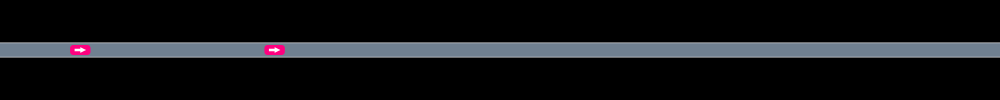
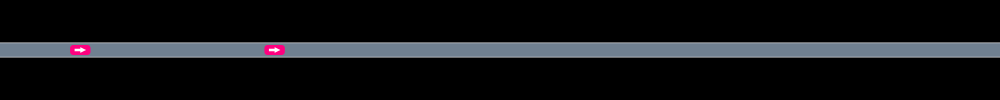

In [60]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam, canvas_height=100)
end

# 2D experimentation

In [ ]:
roadway = gen_straight_roadway(2,1000.0);

In [ ]:
scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)

In [ ]:
models = Dict{Int64, DriverModel}()
models[1] = Tim2DDriver(0.1) # always produce zero acceleration
models[2] = Tim2DDriver(0.1) # default IDM with a desired speed of 12 m/s

nticks = 100
timestep = 0.1
rec = QueueRecord(Vehicle1D, nticks+1, timestep)
simulate!(rec, scene, roadway, models, nticks)